In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import mne


from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

## Load data
Data are stored in EEGLAB format (*.set files) that have also stored the channel locations as well as the events. We could try to implement another process of loading data from the txt OPENBCI format (or the bdf files), for the time being this is the quickest one.

In [16]:
#raw = mne.io.read_raw_eeglab('/home/koutras/Temp/koutras_BCI.set', preload=True)
#raw = mne.io.read_raw_eeglab('/home/koutras/Temp/chris_BCI.set', preload=True)
raw = mne.io.read_raw_eeglab('/home/koutras/Temp/thodoris_BCI.set', preload=True)

Reading /home/koutras/Temp/thodoris_BCI.fdt
Reading 0 ... 399999  =      0.000 ...  1599.996 secs...


<ipython-input-16-0b2390367b2d>:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('/home/koutras/Temp/thodoris_BCI.set', preload=True)


## Extract events from recordings
We are interested in two specific events: LEFT imaginary movement and RIGHT imaginary movement. In our dataset there also exist two other types of events: REST - whan the subject rests between movements and PREPARE shortly before the movement.

In [17]:
event_id = {"LEFT": 1, "RIGHT": 2}  # must be specified for str events

In [18]:
events = mne.events_from_annotations(raw, event_id)[0]

Used Annotations descriptions: ['LEFT', 'RIGHT']


In [19]:
print(raw.annotations)
print('Total annotations: ',len(raw.annotations))

<Annotations | 599 segments: LEFT (100), PREPARE (200), REST (190), RIGHT ...>
Total annotations:  599


## Preprocessing - Filtering

Next step is to filter the data. First we have to apply a notch filter to eliminate the 50Hz harmonics and then a bandpass filter to retain the signal information in the 7-30Hz band.

In [20]:
# Select channels you want
#picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
#                   exclude='bads') #this picks all indeces of the channels we want (all)

# Notch filtering
freqs = (50, 100)
raw = raw.notch_filter(freqs=freqs)

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



<RawEEGLAB | thodoris_BCI.fdt, 8 x 400000 (1600.0 s), ~24.4 MB, data loaded>

## Epoching 
From the continous recordings, we perform epoching considering the LEFT and RIGHT movement onset time. Parameters to be considered are the tmin and tmax prior and after the imaginary movement onset time. Se store in two different arrays epochs_LEFT and epochs_RIGHT and plot the ERP images for each case.

100 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 100 events and 1001 original time points ...
0 bad epochs dropped
100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


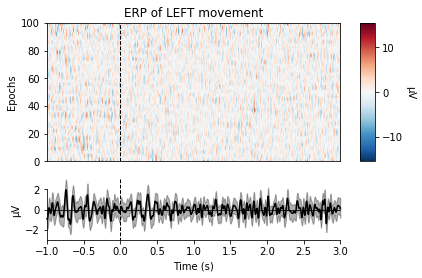

[<Figure size 432x288 with 3 Axes>]

In [26]:
epochs_LEFT = mne.Epochs(raw, events=events, event_id=1, tmin=-1., tmax=3., preload=True)
epochs_LEFT.plot_image(sigma=1.5, title='ERP of LEFT movement', combine='mean')

100 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 100 events and 1001 original time points ...
0 bad epochs dropped
100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "median"


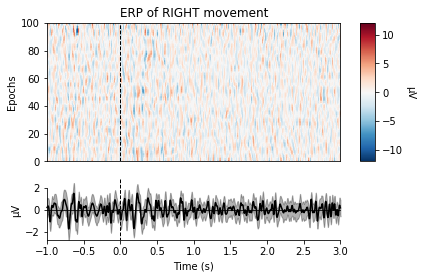

[<Figure size 432x288 with 3 Axes>]

In [43]:
epochs_RIGHT = mne.Epochs(raw, events=events, event_id=2, tmin=-1., tmax=3., preload=True)
epochs_RIGHT.plot_image(sigma=2, title='ERP of RIGHT movement', combine='median')

## PSD plot

Let's see the power spectral density of the electrodes in the two different types of movements. 

#### LEFT Movement

    Using multitaper spectrum estimation with 7 DPSS windows


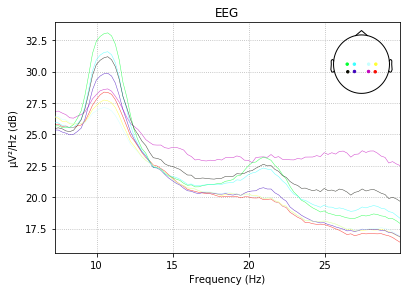

<function matplotlib.pyplot.close(fig=None)>

In [44]:
epochs_LEFT.plot_psd(fmin=7, fmax=30)
plt.close

#### RIGHT Movement

    Using multitaper spectrum estimation with 7 DPSS windows


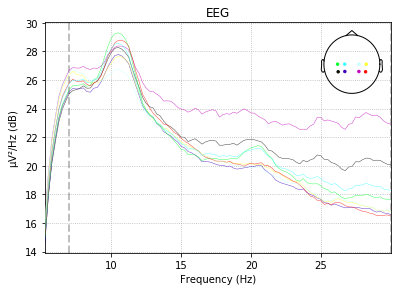

<function matplotlib.pyplot.close(fig=None)>

In [45]:
epochs_RIGHT.plot_psd(fmin=5, fmax=30)
plt.close

and the topographic plots using the electrodes in the different basic frequency bands as well as the 7-30Hz

#### LEFT

    Using multitaper spectrum estimation with 7 DPSS windows


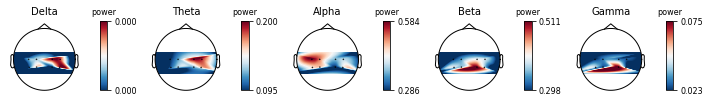

    Using multitaper spectrum estimation with 7 DPSS windows


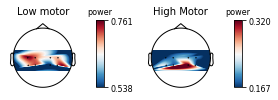

<function matplotlib.pyplot.close(fig=None)>

In [48]:
#this plots topographic plots on head in different frequency bands
epochs_LEFT.plot_psd_topomap(normalize=True) ; plt.close
epochs_LEFT.plot_psd_topomap(bands=[(7,18,'Low motor'),(18,30,'High Motor')],normalize=True) ; plt.close

#### RIGHT

    Using multitaper spectrum estimation with 7 DPSS windows


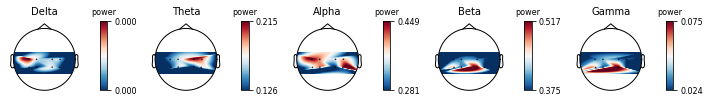

    Using multitaper spectrum estimation with 7 DPSS windows


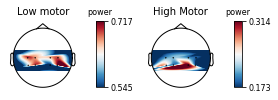

In [53]:
#this plots topographic plots on head in different frequency bands
fig = epochs_RIGHT.plot_psd_topomap(normalize=True) ; 
fig = epochs_RIGHT.plot_psd_topomap(bands=[(7,18,'Low motor'),(18,30,'High Motor')],normalize=True) ;

## Evoked Potentials

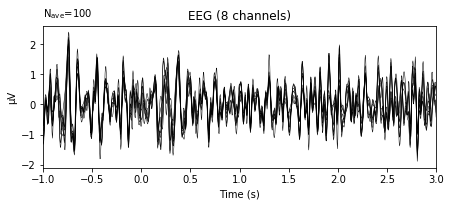

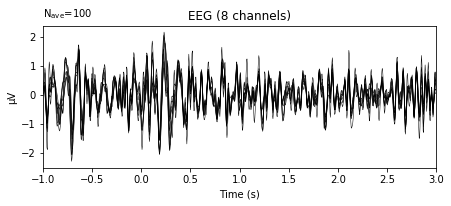

<function matplotlib.pyplot.close(fig=None)>

In [56]:
evoked_LEFT = epochs_LEFT.average()
evoked_LEFT.plot() ; plt.close
evoked_RIGHT = epochs_RIGHT.average()
evoked_RIGHT.plot() ; plt.close


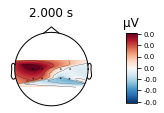

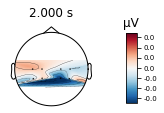

In [60]:
fig = evoked_LEFT.plot_topomap(times=2, average=1.)
fig = evoked_RIGHT.plot_topomap(times=2, average=1.)


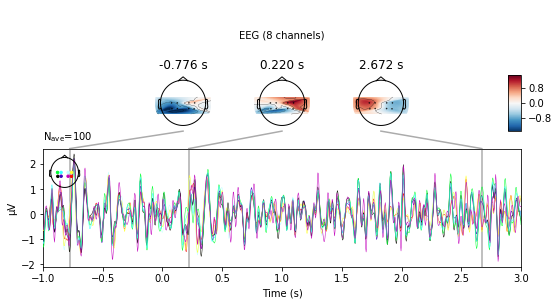

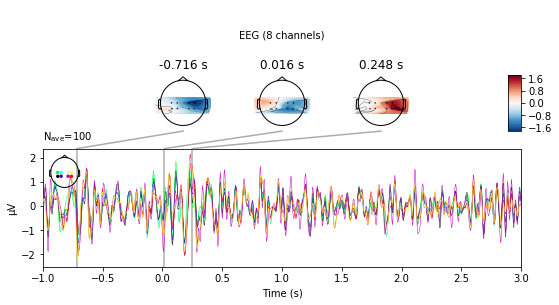

In [305]:
fig = evoked_LEFT.plot_joint()
fig = evoked_RIGHT.plot_joint()

# CSP based BCI (imaginary movements demo)

Let's see if our recordings perform well in discriminating LEFT/RIGHT imaginary movements for our BCI system to work. We will apply Common Spatial Filtering to our recordings to estimate the log variance of the projected data. Then an LDA based classifier is going to be used to test the classification accuracy. All experiments will be performed using a 10 cross validation paradigm with 80% of the data used for training and the remaining 20% for the testing procedure.

For the training phase, the time interval from [-1, 3]sec will be used and a total number of 4 CSP Filters.

In [76]:
epochs = mne.Epochs(raw, events=events, tmin=-1., tmax=4., preload=True, baseline=None, proj=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=3.)
labels = epochs.events[:, -1] - 1

200 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 200 events and 1251 original time points ...
1 bad epochs dropped


### Classification with linear discrimant analysis 

In [77]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)



Computing rank from data with rank=None
    Using tolerance 4.3e-06 (2.2e-16 eps * 8 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-06 (2.2e-16 eps * 8 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-06 (2.2e-16 eps * 8 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-06 (2.2e-16 eps * 8 dim * 2.2e+09  max singular value)
    Estimated rank 

## Classification accuracy using the LDA classifier

In [78]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.935000 / Chance level: 0.502513


### The CSP Filters

Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 8 dim * 5.7e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 8 dim * 4.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


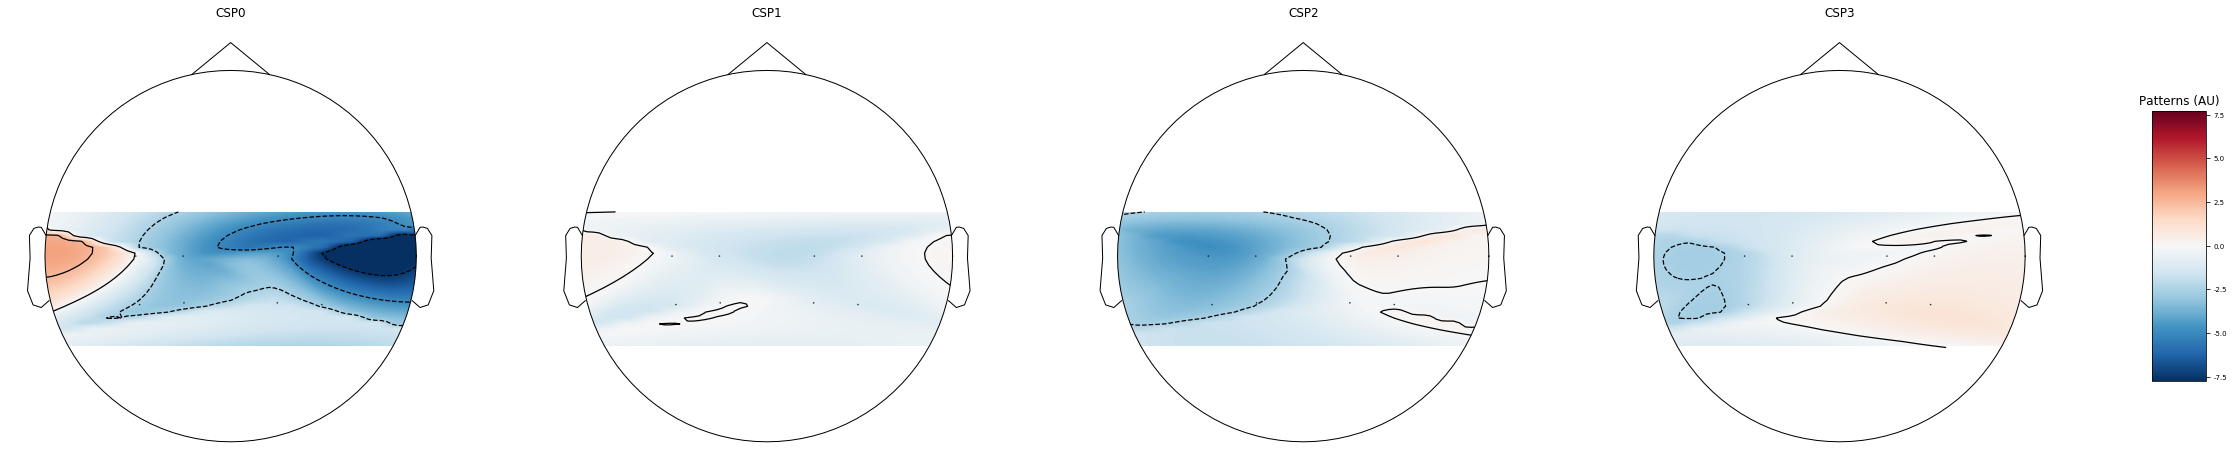

<function matplotlib.pyplot.close(fig=None)>

In [79]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=5)
plt.close

### Classification LEFT/RIGHT over time

In this section we will further test the performance of the classifier by testing and classifying all different time intervals after the movement onset starting from 0 sec (movement onset) to 4sec in 0.5sec moving time windows with 0.1 sec step. Again all experiments are performed in 10 cross validation paradigm.  

In [80]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)



Computing rank from data with rank=None
    Using tolerance 4.3e-06 (2.2e-16 eps * 8 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-06 (2.2e-16 eps * 8 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-06 (2.2e-16 eps * 8 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-06 (2.2e-16 eps * 8 dim * 2.2e+09  max singular value)
    Estimated rank 

### Classification score over time

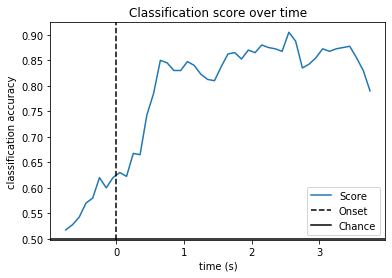

In [81]:
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

We can see that recognition accuracy start at a high point of 85% approximately 600msec after the movement onset and reaches the peak value of 93% about 2.5 secs after the onset. Not bad!

### Decoding in different frequency bands using the Common Spatial Pattern (CSP)

We can also analyze the performance of the CSP and LDA classifier not only by considering different time intervals in the [5-35]Hz band, but also in different frequency bands therein. To do so we perform the same type of classification experiments in different time windows as well as different frequency bands inside the [5-35]Hz initial band. The number of bins is chosen to be 8.

In [82]:
n_splits = 5  # how many folds to use for cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Classification & Time-frequency parameters
tmin, tmax = -1.000, 3.000
n_cycles = 10.  # how many complete cycles: used to define window size
min_freq = 5.
max_freq = 35.
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

In [83]:
# init scores
freq_scores = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = mne.Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    X = epochs.get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                scoring='roc_auc', cv=cv,
                                                n_jobs=1), axis=0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 9.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 9.29 Hz
- Upper transition bandwidth: 2.32 Hz (-6 dB cutoff frequency: 10.45 Hz)
- Filter length: 413 samples (1.652 sec)

200 matching events found
No baseline correction applied
Not setting metadata
Loading data for 200 events and 1701 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 8.2e-06 (2.2e-16 eps * 8 dim * 4.6e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRI

Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 8 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 8 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-06 (2.2e-16 eps * 8 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-06 (2.2e-16 eps * 8 dim * 1.8e+09  max singular value)
    Estimated rank 

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-06 (2.2e-16 eps * 8 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-06 (2.2e-16 eps * 8 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-06 (2.2e-16 eps * 8 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


    Using tolerance 1.7e-06 (2.2e-16 eps * 8 dim * 9.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


### Classification accuracy in different frequency bands

Text(0.5, 1.0, 'Frequency Decoding Scores')

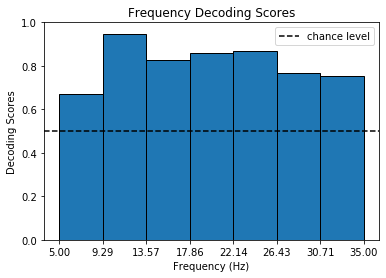

In [84]:
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(len(epochs['LEFT']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

We see that our recordings perform well in the band over the 9.3Hz with the best recognition results in the [9.5 - 13.5]Hz band.

### Decoding in different frequency bands and time intervals using the Common Spatial Pattern (CSP)

We can further analyze the performance of the CSP and LDA classifier not only by considering different time intervals, but also different frequency bands. To do so we perform the same type of classification experiments in different time windows as well as different frequency bands in the initial [5-35]Hz. This way we will result in a matrix type image that will show us visually where in frequency and time our classifier achieves the best recognition results.

In [85]:
# init scores
tf_scores = np.zeros((n_freqs - 1, n_windows))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = mne.Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    # Roll covariance, csp and lda over time
    for t, w_time in enumerate(centered_w_times):

        # Center the min and max of the window
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.

        # Crop data into time-window of interest
        X = epochs.copy().crop(w_tmin, w_tmax).get_data()

        # Save mean scores over folds for each frequency and time window
        tf_scores[freq, t] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                     scoring='roc_auc', cv=cv,
                                                     n_jobs=1), axis=0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 9.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 9.29 Hz
- Upper transition bandwidth: 2.32 Hz (-6 dB cutoff frequency: 10.45 Hz)
- Filter length: 413 samples (1.652 sec)

200 matching events found
No baseline correction applied
Not setting metadata
Loading data for 200 events and 1701 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRI

    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 dat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09 

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Comp

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-06 (2.2e-16 eps * 8 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 8 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 8 dim * 1.3e+09  max singular value)
    Estimated

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 8 dim * 9.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 8 dim * 9.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covaria

    Using tolerance 1.6e-06 (2.2e-16 eps * 8 dim * 9.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 8 dim * 9.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 9.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 d

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 8 dim * 9.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 8 dim * 9.8e

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 9.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 8 dim * 9.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Co

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 8 dim * 1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 8 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covaria

Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.57
- Lower transition bandwidth: 3.39 Hz (-6 dB cutoff frequency: 11.88 Hz)
- Upper passband edge: 17.86 Hz
- Upper transition bandwidth: 4.46 Hz (-6 dB cutoff frequency: 20.09 Hz)
- Filter length: 243 samples (0.972 sec)

200 matching events found
No baseline correction applied
Not setting metadata
Loading data for 200 events and 1319 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with 

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank 

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covaria

    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 d

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.5e+08  max singular value)
    Estimated

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 8 dim * 7.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 8 dim * 6.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 8 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-07 (2.2e-16 eps * 8 dim * 5.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-07 (2.2e-16 eps * 8 dim * 5.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-07 (2.2e-16 eps * 8 dim * 5.6e

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 8 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-07 (2.2e-16 eps * 8 dim * 5.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 8 dim * 5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Co

    Using tolerance 9.1e-07 (2.2e-16 eps * 8 dim * 5.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 8 dim * 5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 8 dim * 5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 dat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-07 (2.2e-16 eps * 8 dim * 4.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-07 (2.2e-16 eps * 8 dim * 4.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 8 dim * 5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 8 dim * 4.7e+0

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-07 (2.2e-16 eps * 8 dim * 5.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Co

    Using tolerance 8.7e-07 (2.2e-16 eps * 8 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9e-07 (2.2e-16 eps * 8 dim * 5.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-07 (2.2e-16 eps * 8 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-07 (2.2e-16 eps * 8 dim * 5.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 d

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-07 (2.2e-16 eps * 8 dim * 5.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 8 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-07 (2.2e-16 eps * 8 dim * 5.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-07 (2.2e-16 eps * 8 dim * 5.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 8 dim * 5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covaria

    Using tolerance 9.3e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-07 (2.2e-16 eps * 8 dim * 5.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-07 (2.2e-16 eps * 8 dim * 5.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 22 - 26 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 22.14
- Lower transition bandwidth: 5.54 Hz (-6 dB cutoff frequency: 19.38 Hz)
- Upper passband edge: 26.43 Hz
- Upper transition bandwidth: 6.61 Hz (-6 dB cutoff frequency: 29.73 Hz)
- Filter length: 149 samples (0.596 sec)

200 matching events found
No baseline correction applied
Not setting metadata
Loading data for 200 events and 1207 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 8 dim * 4.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 8 dim * 4.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 8 dim * 4.7e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-07 (2.2e-16 eps * 8 dim * 4.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 8 dim * 4.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 8 dim * 4.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-07 (2.2e-16 eps * 8 dim * 4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-07 (2.2e-16 eps * 8 dim * 4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated ran

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 8 dim * 4.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 8 dim * 3.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-07 (2.2e-16 eps * 8 dim * 4.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated rank (m

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-07 (2.2e-16 eps * 8 dim * 4.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 8 dim * 4.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-07 (2.2e-16 eps * 8 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covaria

Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 8 dim * 4.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-07 (2.2e-16 eps * 8 dim * 4.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 8 dim * 4.3e+08  max singular value)
    Estimated

    Using tolerance 6.7e-07 (2.2e-16 eps * 8 dim * 3.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 8 dim * 3.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 8 dim * 4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 dat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 8 dim * 4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-07 (2.2e-16 eps * 8 dim * 3.5e+08 

    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-07 (2.2e-16 eps * 8 dim * 3.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-07 (2.2e-16 eps * 8 dim * 3.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-07 (2.2e-16 eps * 8 dim * 3.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Co

    Using tolerance 6.1e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-07 (2.2e-16 eps * 8 dim * 3.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-07 (2.2e-16 eps * 8 dim * 3.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-07 (2.2e-16 eps * 8 dim * 3.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-07 (2.2e-16 eps * 8 dim * 3.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-07 (2.2e-16 eps * 8 dim * 3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covarianc

    Using tolerance 5.8e-07 (2.2e-16 eps * 8 dim * 3.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-07 (2.2e-16 eps * 8 dim * 3.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-07 (2.2e-16 eps * 8 dim * 3.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 8 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-07 (2.2e-16 eps * 8 dim * 3.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-0

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-07 (2.2e-16 eps * 8 dim * 3.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-07 (2.2e-16 eps * 8 dim * 3.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 8 dim * 3.9e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-07 (2.2e-16 eps * 8 dim * 3.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 31 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.71
- Lower transition bandwidth: 7.68 Hz (-6 dB cutoff frequency: 26.88 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 107 samples (0.428 sec)

200 matching events found
No baseline correction applied
Not setting metadata
Loading data for 200 events and 1153 original time points ...
0 

    Using tolerance 4.9e-07 (2.2e-16 eps * 8 dim * 2.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 8 dim * 2.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-07 (2.2e-16 eps * 8 dim * 3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 d

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e-07 (2.2e-16 eps * 8 dim * 2.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 8 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-07 (2.2e-16 eps * 8 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-0

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 8 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-07 (2.2e-16 eps * 8 dim * 2.2e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 8 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 8 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 8 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-07 (2.2e-16 eps * 8 dim * 2.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-07 (2.2e-16 eps * 8 dim * 2.1e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

    Using tolerance 4.6e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 8 dim * 2.6e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-07 (2.2e-16 eps * 8 dim * 2.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-07 (2.2e-16 eps * 8 dim * 2.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8

Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-07 (2.2e-16 eps * 8 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-07 (2.2e-16 eps * 8 dim * 2.7e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 8 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e

    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 8 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-07 (2.2e-16 eps * 8 dim * 2.8e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.1e-07 (2.2e-16 eps * 8 dim * 2.3e+08  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covar

### Classification accuracy in the time-frequency space

No baseline correction applied


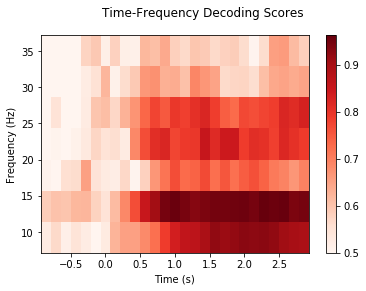

<function matplotlib.pyplot.close(fig=None)>

In [86]:
# Set up time frequency object
av_tfr = mne.time_frequency.AverageTFR(mne.create_info(['freq'], sfreq), tf_scores[np.newaxis, :],
                    centered_w_times, freqs[1:], 1)

chance = np.mean(y)  # set chance level to white in the plot
av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)
plt.close


We can now see clearly that the recognition is the best in the band 11-15Hz and for approximately 800msec after the movement onset until 3sec.

## Plot ERDS

In this final section we will plot the Event related Synchronization / Desynchronization on the electrode space. We are using two electrodes the CP3 and CP2, feel free to try any other ones.

In [88]:
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [89]:
picks = mne.pick_channels(raw.info["ch_names"], ["CP3", "CP4"])

# epoch data ##################################################################
tmin, tmax = -0.5, 3  # define epochs around events (in s)
event_ids = dict(LEFT=1, RIGHT=2)  # map event IDs to tasks
epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)

200 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 200 events and 1126 original time points ...
0 bad epochs dropped


In [90]:
# compute ERDS maps ###########################################################
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None)  # for cluster test

Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.660391
stat_fun(H1): min=-9.255507 max=4.851047
Running initial clustering
Found 21 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.660391
stat_fun(H1): min=-9.255507 max=4.851047
Running initial clustering
Found 55 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.660391
stat_fun(H1): min=-3.697161 max=5.379640
Running initial clustering
Found 20 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.660391
stat_fun(H1): min=-3.697161 max=5.379640
Running initial clustering
Found 36 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.660391
stat_fun(H1): min=-6.585165 max=6.301623
Running initial clustering
Found 18 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.660391
stat_fun(H1): min=-6.585165 max=6.301623
Running initial clustering
Found 52 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.660391
stat_fun(H1): min=-11.393760 max=5.433583
Running initial clustering
Found 21 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.660391
stat_fun(H1): min=-11.393760 max=5.433583
Running initial clustering
Found 50 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


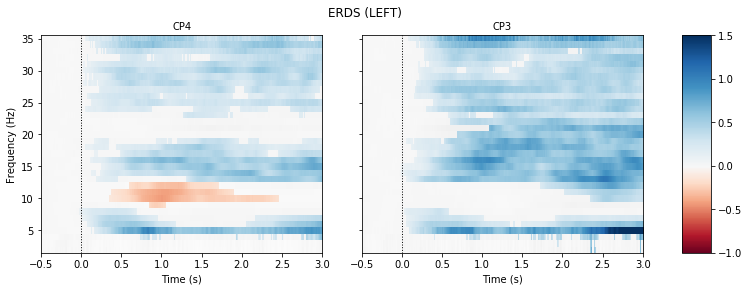

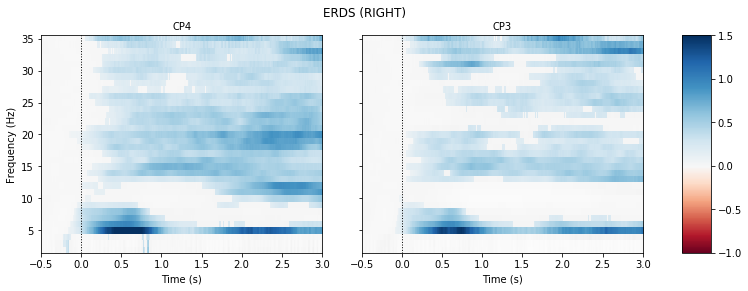

In [91]:
# Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,
                     decim=2)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 1]})
    for ch,ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))

In our results, we map ERD to red color and ERS to blue color 